# GCP Vertex AI.

The following are the step that I followed to setup GCP Vertex AI.

* Enable appropriate (Vertex AI) API.
* Create a notebook instance.
* Create a cloud storage if necessary.

The main components of GCP Vertex AI are:
* Datasets
* Features
* Labelling tasks
* Notebooks
* AutoML
* Pipelines
  
This notebook demonstrates how one could train and deploy the model on GCP Vertex AI.


### Local machine training.


In [1]:
# Importing libraries.
import os
import torch
import torch.optim as optim
from setup import net, data, train, test, utils, config

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


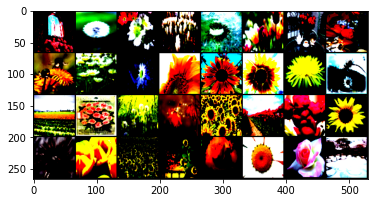

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to ./__models__/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.03MB/s]


In [2]:
os.environ['TORCH_HOME'] = config.config.model_dir
DEVICE = torch.device(config.config.device)
_data = data.Data(data_dir=config.config.data_dir, train_batch_size=config.config.train_batch_size, test_batch_size=config.config.test_batch_size)
_data.visualize()
TRAIN_LOADER, TEST_LOADER = _data.get_loaders()
MODEL = net.Resnet18().get_model(num_classes=config.config.num_classes).to(DEVICE)
OPTIMIZER = optim.SGD(MODEL.parameters(), lr=config.config.lr, momentum=config.config.momentum)
CRITERION = torch.nn.CrossEntropyLoss()
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, 'min', patience=config.config.patience)

In [3]:
train_loss, saved_path = train.Train(
    model=MODEL,
    train_loader=TRAIN_LOADER,
    optimizer=OPTIMIZER,
    criterion=CRITERION,
    scheduler=SCHEDULER,
    epochs=config.config.epochs,
    device=DEVICE,
    save_path_dir=config.config.save_path_dir,
    verbose=config.config.verbose,
    verbose_step=config.config.verbose_step
).train()


DEVICE - cuda || EPOCHS - 10 || LEARNING RATE - 0.001.


EPOCH - 1/10 || START AT - 14:47:21 26|06|2021 || LEARNING RATE - 0.001

/home/tyche/miniconda3/envs/ai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
	EPOCH - 1/10 || TRAIN LOSS - 1.00258 || TIME ELAPSED - 22.23s.


EPOCH - 2/10 || START AT - 14:47:43 26|06|2021 || LEARNING RATE - 0.001

	EPOCH - 2/10 || TRAIN LOSS - 0.58836 || TIME ELAPSED - 21.72s.


EPOCH - 3/10 || START AT - 14:48:05 26|06|2021 || LEARNING RATE - 0.001

	EPOCH - 3/10 || TRAIN LOSS - 0.44042 || TIME ELAPSED - 21.06s.


EPOCH - 4/10 || START AT - 14:48:26 26|06|2021 || LEARNING RATE - 0.001

	EPOCH - 4/10 || TRAIN LOSS 

In [4]:
image_set, label_set, pred_set, model = test.Test(
    model=MODEL,
    test_loader=TEST_LOADER,
    device=DEVICE,
    save_path=saved_path,
    test_run=config.config.test_run
).test()

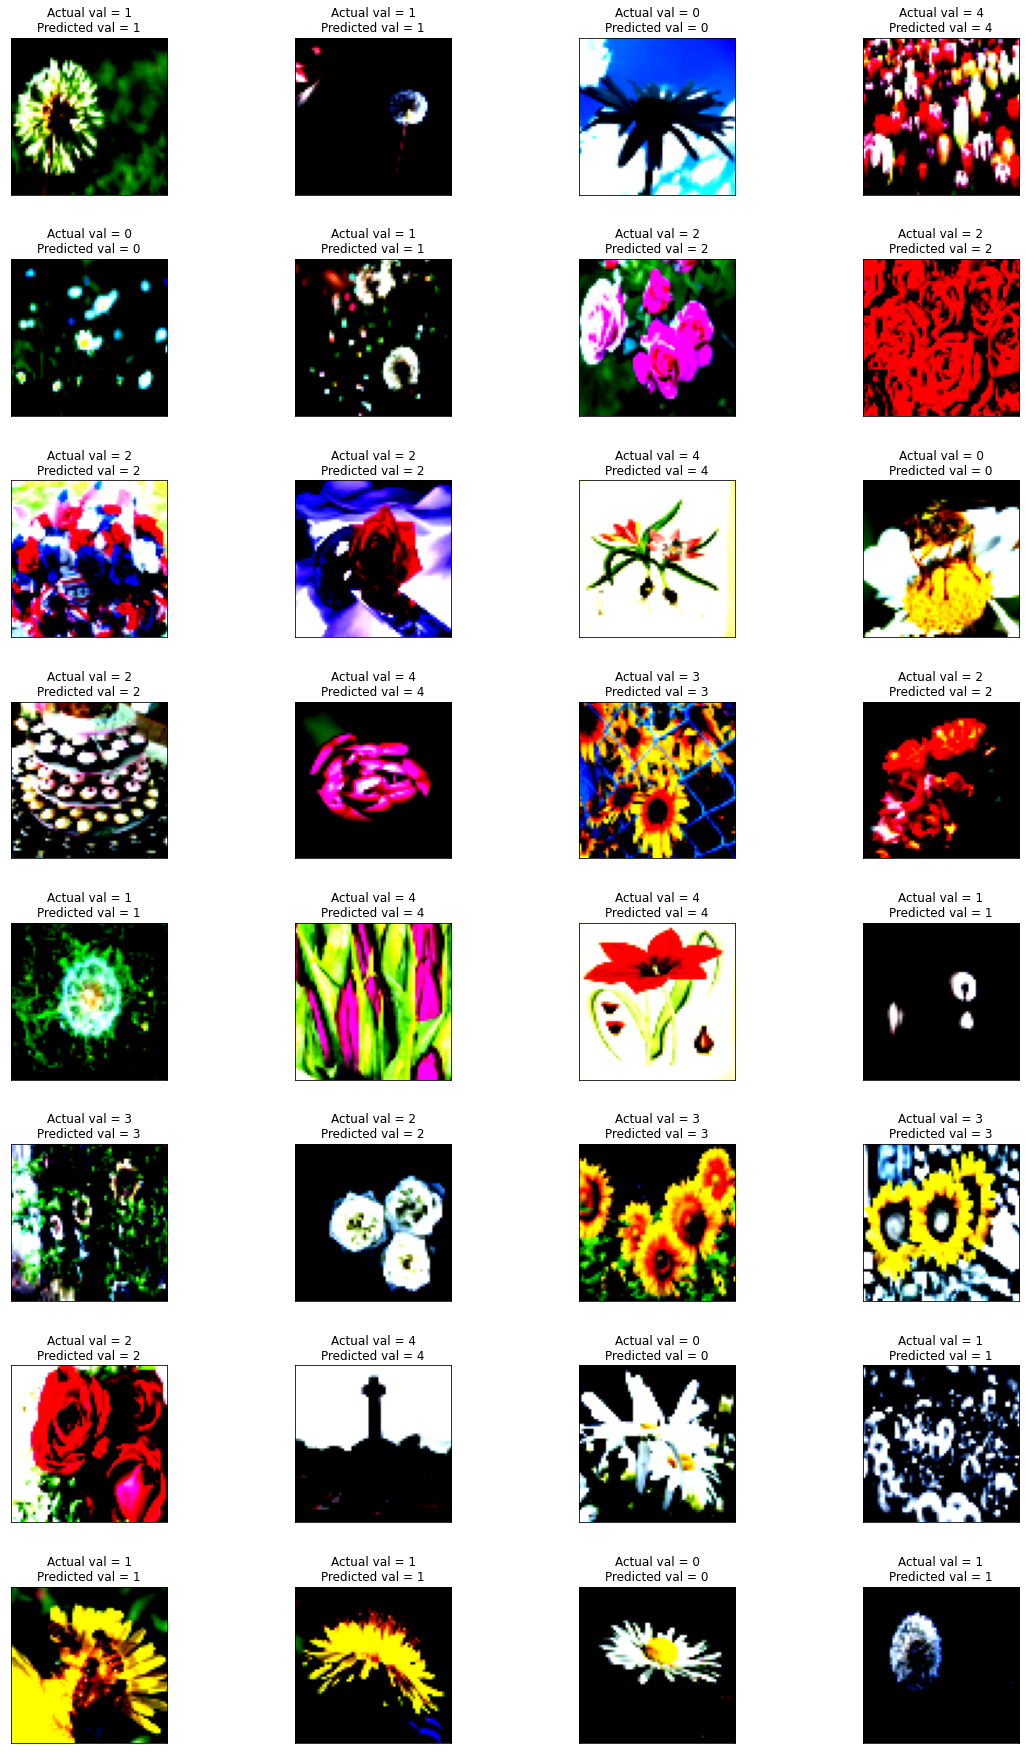

In [5]:
utils.plot_output(image_set, label_set, pred_set)

### Training using VertexAI

In [2]:
# Cell must be executed  only if you are using google colab or local system.
import sys
from dotenv import load_dotenv
load_dotenv()
if "google.colab" in sys.modules:
    # Google colab authentication to use GCP.
    from google.colab import auth as google_auth
    google_auth.authenticate_user()
else:
    # Loacl system authentication to use GCP.
    %env GOOGLE_APPLICATION_CREDENTIALS {os.getenv('GOOGLE_APPLICATION_CREDENTIALS', '')}

env: GOOGLE_APPLICATION_CREDENTIALS=./__secrets__/project-v2-318004-b04d33cb80ee.json


In [3]:
# Import libraries.
from google.cloud import storage
from google.cloud import aiplatform

In [4]:
# # Rename the folders and push it to the storage bucket if you are running for thee first time and the data is freshly installed.
# utils.rename_files(data_dir=config.config.data_dir)
# !gsutil -m cp -r ./__data__/flower_photos gs://vertexai_bucket/datasets

In [5]:
# # Run this cell only if you are using google colab.
# PROJECT_ID = '[your-project-id]' # TODO (Set to your GCP Project name).
# BUCKET_NAME = '[your-bucket-name]' # TODO (Set to your GCS Bucket name).
# REGION = '[region]' # TODO (Set to your Region).
# !gcloud config set project {PROJECT_ID}

In [6]:
# # Run this cell if you want to download data and record models.
# !mkdir __data__
# !mkdir __models__
# !gsutil -m cp -r gs://vertexai_bucket/datasets/flower_photos .  

#### Part 1 - Uploading the trained model and deploying it.

In [6]:
## Run this to create a package distribution and upload it to GCS.
# !python setup_1.py sdist --formats=gztar
# !gsutil cp ./dist/setup-0.1.tar.gz gs://vertexai_bucket/setups/flower_classification/

In [7]:
# Initializing VertexAI.
aiplatform.init(
        project=os.getenv('PROJECT_ID', ''), # Porject ID.
        location=os.getenv('REGION', ''), # VertexAI region, default is 'us-central1'
        staging_bucket=os.getenv('BUCKET_NAME', ''), # Bucket in the same region defined by VertexAI
    )

In [13]:
def create_custom_job(project, location, display_name, container_image_uri, gcs_package_uri, entry_point, replica_count, machine_type, accelerator_type, accelerator_count, api_endpoint="us-central1-aiplatform.googleapis.com",
):
    client_options = {"api_endpoint": api_endpoint}
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    custom_job = {
        "display_name": display_name,
        "job_spec": {
            "worker_pool_specs": [
                {
                    "machine_spec": {
                        "machine_type": machine_type,
                        "accelerator_type": accelerator_type,
                        "accelerator_count": accelerator_count,
                    },
                    "replica_count": replica_count,
                    # "container_spec": {
                    #     "image_uri": container_image_uri,
                    #     "command": [],
                    #     "args": [],
                    # },
                    "python_package_spec":{
                        "executor_image_uri": container_image_uri,
                        "packageUris": [
                            gcs_package_uri
                        ],
                        "pythonModule": entry_point,
                        "args": [],
                        "env": []
                    }
                }
            ]
        },
    }
    parent = f"projects/{project}/locations/{location}"
    response = client.create_custom_job(parent=parent, custom_job=custom_job)
    print("response:", response)

project, location, bucket_uri = os.getenv("PROJECT_ID", ''), os.getenv("REGION", ''), os.getenv("BUCKET_URI", '')
create_custom_job(
    project=project,
    location=location,
    display_name="flower_classification",
    container_image_uri="us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-7:latest",
    gcs_package_uri=f"{bucket_uri}/setups/flower_classification/",
    entry_point="setup.pyrun_train.py",
    replica_count=1,
    machine_type="n1-standard-4",
    accelerator_type="NVIDIA_TESLA_K80",
    accelerator_count=1,
)

ValueError: Protocol message PythonPackageSpec has no "executorImageUri" field.

In [ ]:
# Running training job.
os.environ['AIP_MODEL_DIR'] = '~/tmp'
job = aiplatform.CustomTrainingJob(
    display_name="flower-dataset-training-job",
    script_path="./setup/run_train.py",
    container_uri="gcr.io/cloud-aiplatform/training/tf-cpu.2-2:latest",
    requirements=["gcsfs==0.7.1"],
    model_serving_container_image_uri="gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-2:latest",
)

model = job.run(my_dataset,
                replica_count=1,
                machine_type="n1-standard-4",
                accelerator_type='NVIDIA_TESLA_K80',
                accelerator_count=1)